### Chromatic dispersion Iterative
- read a buffer (binary file) into np.array
- define a set of coefficients for chromatic disp comp
- apply those to the spectra
- FFT
- (log scaling) optional
- measure variance of the image (proxy for contrast)

In [81]:
import numpy as np
import matplotlib.cbook as cbook #needed to load the binary file
import os
%matplotlib nbagg
import matplotlib.pyplot as plt
from scipy.stats import zscore
import struct
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import LightSource
import imageio
from PIL import Image
from matplotlib import cm
import tifffile
# import opencv as cv2

In [82]:
## KEEP ONLY ONE:
# user = 'luca'
user = 'fabio'
print(f"User {user} selected")

# file = r"C:\Users\lucab\Google Drive\01 - OCT\Axial Resolution and sampling\test_1_trLVL163_delay16_ND4_Depth_150mm.bin"
# file = r"C:\Users\lucab\Google Drive\01 - OCT\Axial Resolution and sampling\12mm"
file = r"/Users/fabioferoldi/Box/AGI/OCT data/2020.03.13_20112R_ganglion_imaging/test_03.bin"
fname = os.path.basename(file)

User fabio selected


In [83]:
## To read the length of the header, from
# https://books.google.nl/books?id=bIZHCgAAQBAJ&pg=PT149&lpg=PT149&dq=matplotlib+cbook+for+binary+with+header&source=bl&ots=mOirMtJP6U&sig=ACfU3U1Slj4Y2r4Xkl4sKuFsBna9Syog6A&hl=en&sa=X&ved=2ahUKEwiY34fLn9fpAhUL8KQKHaIFD-oQ6AEwBHoECAoQAQ#v=onepage&q=matplotlib%20cbook%20for%20binary%20with%20header&f=false  
with open(file, 'rb') as fp:
    img = memoryview(fp.read())
    
if user == 'fabio':
    header_size = 256
    header_length_format = '>'+str(header_size)+'c'# the first 3 blocks of 16bytes define the header's length
    header = img[:header_size] # first 256 char
    header = struct.unpack(header_length_format, header)
    #### missing: converting the separate bytes into one variable header[18:22]
    h = "".join([el.decode('utf-8') for el in header])
    print(h)
    spectrumsize = int(h[18:22])
    fftsize = int(h[32:36])
    linesize = int(3/2*fftsize)
    bscansize = int(h[49:53])
    datatype = np.dtype('>i2')
    del header
elif user == 'luca':
    datatype = np.dtype('u2')
    header_size = 0
    linesize = 2048
    bscansize  = 256
    spectrumsize = 2048

filesize = os.path.getsize(file) - header_size  
buffersize = linesize * bscansize * datatype.itemsize
cscansize = (filesize-header_size) // buffersize

256 Spectrum_size 1504 FFT_size 2048 Buffer_size 1000 Fast_axis_pixels  512 ampl(mV) 1300 offset(mV)     0 Slow_axis_pixels  300 ampl(mV) 1300 offset(mV)     0   163                                                                                           


In [84]:
def disp_comp(raw, k, a2=0, a3=0,):
    """
    Takes a spectrum and applies a dispersion compensation curve
    
    Parameters
    ----------
    raw [1D np.array]
        spectrum of the raw data
        
    k [1D np.array]]
        the normalized array with the k-space over which the compensation curve is defined
        '''
        k = np.arange(raw.shape[0])
        k = zscore(k)
        '''
    
    a2, a3 : [float]
        2nd and 3rd degree coefficients of the polynomial compensation 
    
    Returns
    ----------
    bscan 
    """
    spectrumsize = raw.shape[0]
    curve = np.polyval([a3, a2, 0, 0], k)
    disp_comp = np.exp(1j*curve, dtype='complex128').reshape(spectrumsize,1)
    raw = np.multiply(raw, disp_comp, dtype='complex128')
    bscan = 20*np.log10(
                    np.abs(
                        np.fft.fft(raw, axis = 0)[:spectrumsize//2] # this can be done on GPU! 
                    ),
                dtype = np.float
        )
#     bscan = np.abs(
#                     np.fft.fft(raw, axis = 0)[:spectrumsize//2] # this can be done on GPU! 
#                   )
    return bscan

In [85]:
# take the c-th buffer (that will become a B-scan) 
c = 0
raw = np.frombuffer(img[header_size+c*buffersize:header_size+(c+1)*buffersize], 
                    dtype=datatype )
raw = raw.reshape((bscansize, linesize)).T

# fabio's A-scans have the FFT's magnitude appended - we remove it
if user=='fabio': raw = raw[:spectrumsize, :]

# apply Hanning window
raw = np.multiply( 
        raw, 
        np.hanning(spectrumsize).reshape(spectrumsize,1)) # reshape is only a view, no extra memory ussage

# create k-space and normalize it
k = np.arange(spectrumsize)
k = zscore(k)

variance = {}
n_a2 = 25
n_a3 = 15
a2_range = np.linspace(-10, 10, num = n_a2)
a3_range = np.linspace(-3, 3, num = n_a3)



In [47]:
print(a3_range)


[-0.01  -0.005  0.     0.005  0.01 ]


In [52]:
## Iteration over all the combinations of a2 and a3 coefficients
variance = np.empty((n_a2, n_a3, 2))
for i in range(n_a2):
    for j in range(n_a3):
        BSCAN = disp_comp(raw, k, a3=a3_range[j], a2 = a2_range[i])
        ## testing two measures of contrast
        variance[i][j][0] = np.var(BSCAN) # whole img variance
        variance[i][j][1] = np.mean(np.var(BSCAN, axis=1)) # avg of axial variances
        
    print(f"Progress {(i+1)/n_a2*100:5.4}%") # f-strings
    
    
    
    
    

Progress   4.0%
Progress   8.0%
Progress  12.0%
Progress  16.0%
Progress  20.0%
Progress  24.0%
Progress  28.0%
Progress  32.0%
Progress  36.0%
Progress  40.0%
Progress  44.0%
Progress  48.0%
Progress  52.0%
Progress  56.0%
Progress  60.0%
Progress  64.0%
Progress  68.0%
Progress  72.0%
Progress  76.0%
Progress  80.0%
Progress  84.0%
Progress  88.0%
Progress  92.0%
Progress  96.0%
Progress 100.0%


<IPython.core.display.Javascript object>


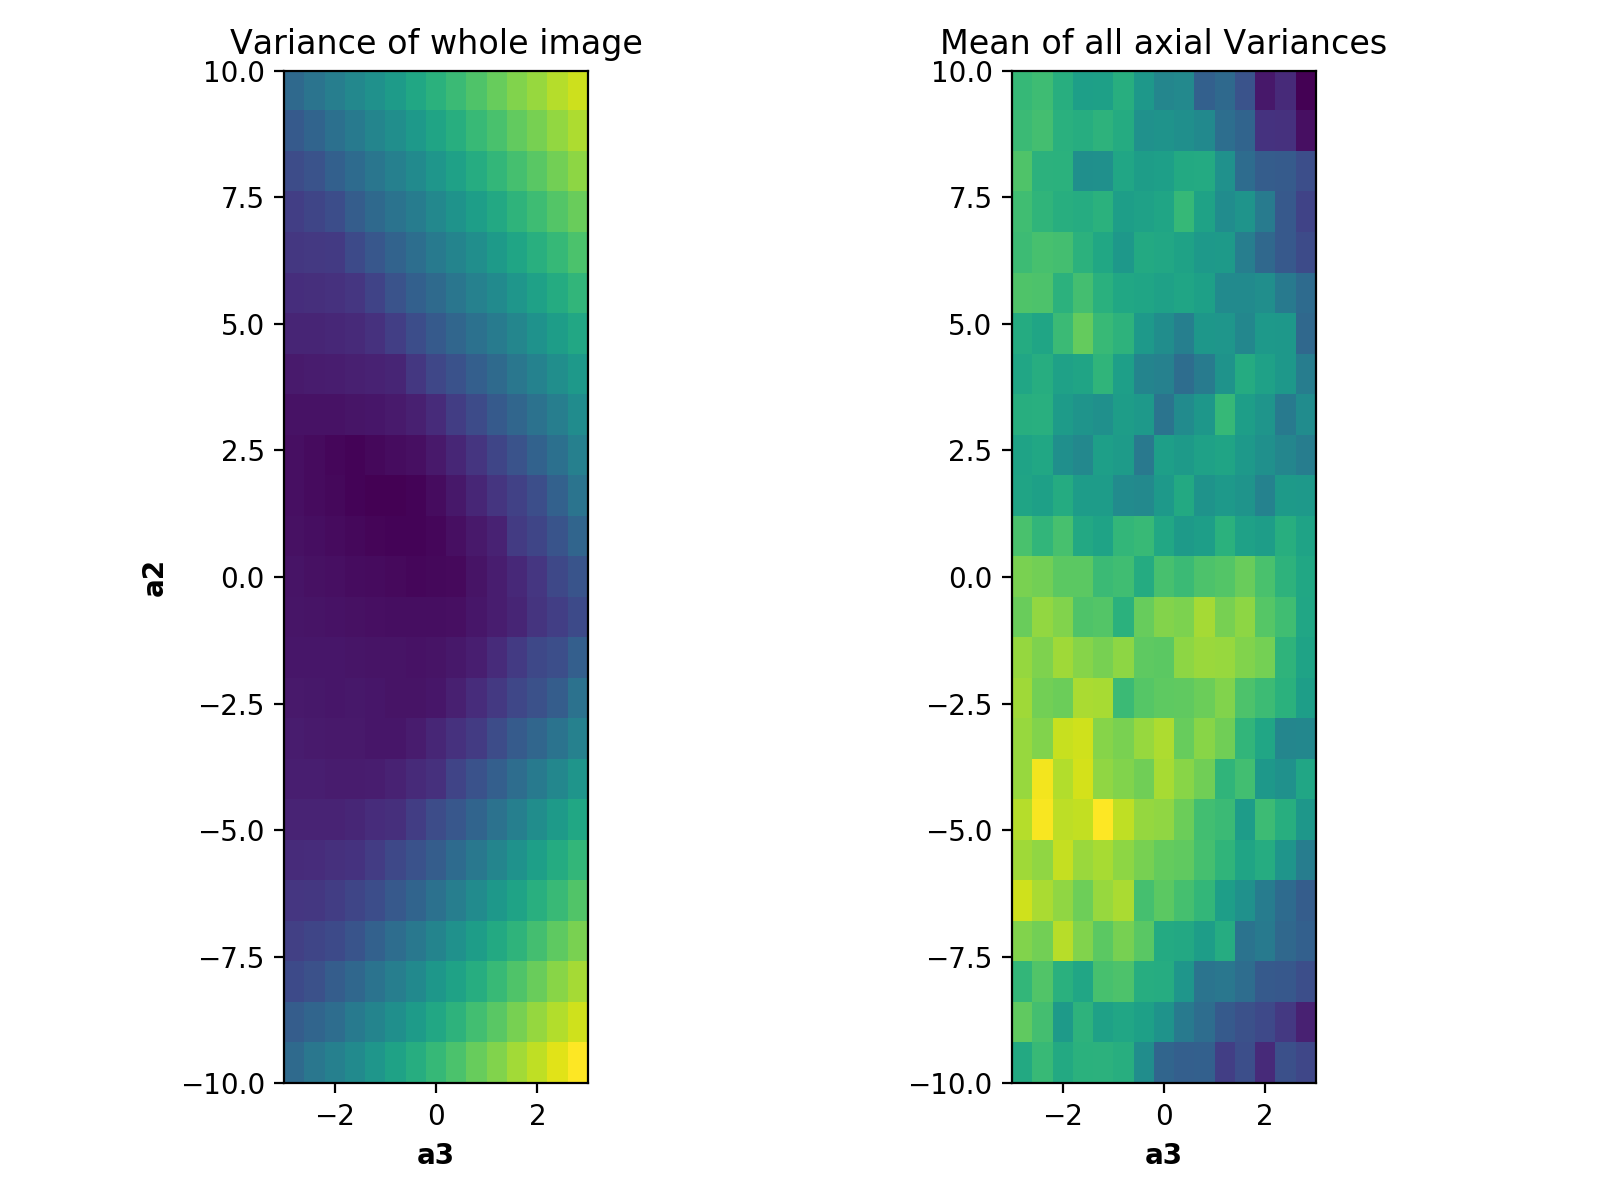

In [87]:
fig,ax = plt.subplots(ncols=2, figsize= (8,6))
extent = [min(a3_range), max(a3_range), min(a2_range), max(a2_range)]
ax[0].imshow(variance[:,:,0], extent=extent, interpolation = 'nearest')
ax[0].title.set_text('Variance of whole image')
ax[0].set_xlabel('a3', weight = 'bold')
ax[0].set_ylabel('a2', weight = 'bold')


ax[1].imshow(variance[:,:,1], extent=extent, interpolation = 'nearest')
ax[1].title.set_text('Mean of all axial Variances')
ax[1].set_xlabel('a3', weight = 'bold')

plt.tight_layout()






In [ ]:
# from: 
# https://stackoverflow.com/questions/11409690/plotting-a-2d-array-with-mplot3d
# Set up grid and test data
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111, projection='3d')

X, Y = np.meshgrid(a3_range, a2_range)  # `plot_surface` expects `x` and `y` data to be 2D

# ax.plot_wireframe(X, Y, zscore(variance[:,:,0]), label = "variance")
ax.plot_surface(X, Y, variance[:,:,0], 
                label = "mean of axial variances", 
                color = 'forestgreen',
                cmap = 'viridis',
                edgecolor = 'k'
               )

ax.view_init(elev=51., azim=-41) # visualize the surf from this direction

fig.show()

In [ ]:
result = np.where(variance[:,:,0] == np.amin(variance[:,:,0]))
 
print(f'Tuple of arrays returned : {a3_range[result[0]]} n3 and {a2_range[result[0]]} n2', )

In [ ]:
with AppendingTiffWriter(OUTFILE) as tf:
        for extend in extends:
            im = Image.effect_mandelbrot(size, extend, 100)
            im.save(tf)
            tf.newFrame()
            
            
im.save(out, save_all=True, append_images=[im1, im2, ...])            
            
for m in a:
    imlist.append(Image.fromarray(m))

imlist[0].save("test.tif", compression="tiff_deflate", save_all=True,
               append_images=imlist[1:])
            

In [86]:
# Iteration over all the combinations of a2 and a3 coefficients
variance = np.empty((n_a2, n_a3, 2))

# width, height = im.size
scale_fac = 4
height, width = raw.shape
size_output_images = [int(np.around(height/(2*scale_fac))),int(np.around(width/scale_fac)) ]

first_img = True # is it the first Frame?
img_name = fname[:-4]+'.tif'

min_v = 110
max_v = 70

for i in range(n_a2):
    for j in range(n_a3):
        BSCAN = disp_comp(raw, k, a3=a3_range[j], a2 = a2_range[i])
        ## BScan as of now is an array of dtype=float (which is 64bits per pixel)
        
        variance[i][j][0] = np.var(BSCAN) # whole img variance
        variance[i][j][1] = np.mean(np.var(BSCAN, axis=1)) # avg of axial variances
        # NOT NEEDED FOR NOW
#         Bscan_im = Image.fromarray((BSCAN)) 
#         Bscan_im = Bscan_im.resize(size_output_images) 
#         BSCAN = np.array(Bscan_im)
        
     
        BSCAN = (BSCAN - min_v)/(max_v-min_v)
        BSCAN[BSCAN > 1] = 1
        BSCAN[BSCAN < 0] = 0     
        BSCAN=(BSCAN*255).astype(np.uint8)
        
        if first_img:
#             Bscan_im.save(img_name)
            with tifffile.TiffWriter(img_name) as tif:
                tif.save(BSCAN)
            first_img = False # following iterations will execute the 'else' statement below
            
        else:
#             Bscan_im.save(img_name, 
#                           append_images=True, 
#                           compression="tiff_deflate")
#             with tifffile.TiffWriter(img_name) as tif:
#                 tif.save(BSCAN.astype(np.float), appe)
            tifffile.imwrite(img_name, 
                                 BSCAN,
                                 append=True, 
                                )
    
    if i % round(n_a2*n_a3/20) == 0:
        print(f"Progress {(i+1)/n_a2*100}%") # f-strings
        
# imlist[0].save("test.tif", compression="tiff_deflate", save_all=True,
#                append_images=imlist[1:])

result = np.where(variance[:,:,0] == np.amin(variance[:,:,0]))
print(result)
print(f'Tuple of arrays returned : {a3_range[result[1]]} n3 and {a2_range[result[0]]} n2', )

Progress 4.0%
Progress 80.0%
(array([10]), array([5]))
Tuple of arrays returned : [-0.85714286] n3 and [-1.66666667] n2
